# 一、 基于Oxford-IIIT Pet数据集实现PaddleHub猫咪一键抠图

## 1.主要工作
* 从Oxford-IIIT Pet宠物数据集提取cat据集
* 重新制作label，背景设置为0，图像设置为1
* 最终iter 2100时， mIoU =0.7874，仍有上升空间，只是耗时较长，不再训练
* 通过paddlehub部署导出的静态模型

模型文件见当前目录 **model.gz** ， paddlehub部署见 **catseg_mobile.zip** 。

最后就可以完美抠图了，可以制作猫猫证件照了。



## 2.PaddleSeg简介
PaddleSeg是基于飞桨PaddlePaddle开发的端到端图像分割开发套件，涵盖了高精度和轻量级等不同方向的大量高质量分割模型。通过模块化的设计，提供了配置化驱动和API调用两种应用方式，帮助开发者更便捷地完成从训练到部署的全流程图像分割应用。

**特性**

* 高精度模型： 基于百度自研的半监督标签知识蒸馏方案（SSLD）训练得到高精度骨干网络，结合前沿的分割技术，提供了50+的高质量预训练模型，效果优于其他开源实现。
* 模块化设计： 支持15+主流 分割网络 ，结合模块化设计的 数据增强策略 、骨干网络、损失函数 等不同组件，开发者可以基于实际应用场景出发，组装多样化的训练配置，满足不同性能和精度的要求。
* 高性能： 支持多进程异步I/O、多卡并行训练、评估等加速策略，结合飞桨核心框架的显存优化功能，可大幅度减少分割模型的训练开销，让开发者更低成本、更高效地完成图像分割训练。

In [ ]:
! git clone https://gitee.com/paddlepaddle/PaddleSeg.git  --depth=1

Cloning into 'PaddleSeg'...
remote: Enumerating objects: 1589, done.
remote: Counting objects: 100% (1589/1589), done.
remote: Compressing objects: 100% (1354/1354), done.
remote: Total 1589 (delta 309), reused 1117 (delta 142), pack-reused 0
Receiving objects: 100% (1589/1589), 88.49 MiB | 5.57 MiB/s, done.
Resolving deltas: 100% (309/309), done.
Checking connectivity... done.


## 3.数据集制作

> 需要手动删除dataset/annotations/list.txt文件头，便于pandas读取，如麻烦，可以直接使用已制作好的数据集二，cat数据集。

In [1]:
# 解压缩数据集
!mkdir dataset
!tar -xvf data/data50154/images.tar.gz -C dataset/
!tar -xvf data/data50154/annotations.tar.gz -C dataset/

In [3]:
# 查看list文件
!head -n 10 dataset/annotations/list.txt

#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images
Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1


In [13]:
# 删除文件前6行描述头，方便pandas读取
!sed -i '1,6d' dataset/annotations/list.txt

In [14]:
!head dataset/annotations/list.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


In [ ]:
import pandas as pd
import shutil
import os


# Image CLASS-ID SPECIES BREED ID
# ID: 1:37 Class ids
# SPECIES: 1:Cat 2:Dog
# BREED ID: 1-25:Cat 1:12:Dog
# All images with 1st letter as captial are cat images
# images with small first letter are dog images
# ._Abyssinian_100.png

def copyfile(animal, filename):
    # image\label列表
    file_list = []
    image_file = filename + '.jpg'
    label_file = filename + '.png'

    if os.path.exists(os.path.join('dataset/images', image_file)):
        shutil.copy(os.path.join('dataset/images', image_file), os.path.join(f'{animal}/images', image_file))
        shutil.copy(os.path.join('dataset/annotations/trimaps', label_file),
                    os.path.join(f'{animal}/labels', label_file))
        temp = os.path.join('images/', image_file) + ' ' + os.path.join('labels/',label_file) + '\n'
        file_list.append(temp)
    with open(os.path.join(animal, animal + '.txt'), 'a') as f:
        f.writelines(file_list)


if __name__ == "__main__":

    data = pd.read_csv('dataset/annotations/list.txt', header=None, sep=' ')
    data.head()

    cat = data[data[2] == 1]
    dog = data[data[2] == 2]

    for item in cat[0]:
        copyfile('cat', item)

    for item in dog[0]:
        copyfile('dog', item)


In [ ]:
# 删除无用数据
!rm dataset/ -rf

##  4.训练自定义的数据集

### 4.1文件结构

```
├── cat.txt
├── images
│   ├── Abyssinian_100.jpg
│   ├── Abyssinian_101.jpg
│   ├── ...
├── labels
│   ├── Abyssinian_100.png
│   ├── Abyssinian_101.png
│   ├── ...
```

### 4.2 列表内容：

```
images/Abyssinian_1.jpg labels/Abyssinian_1.png
images/Abyssinian_10.jpg labels/Abyssinian_10.png
images/Abyssinian_100.jpg labels/Abyssinian_100.png
...
```


### 4.3.数据查看

/home/aistudio
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333 at 0x7F203C05FBD0>


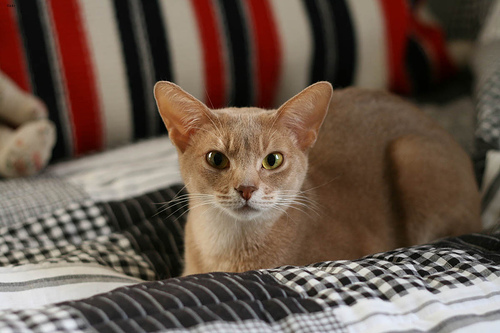

In [3]:
%cd ~
from PIL import Image

img=Image.open('cat/images/Abyssinian_123.jpg')
print(img)
img

<PIL.PngImagePlugin.PngImageFile image mode=L size=500x333 at 0x7F203C0574D0>


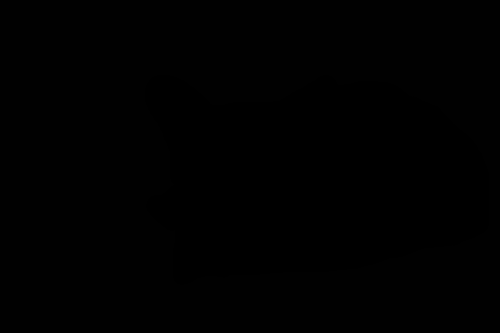

In [5]:
img=Image.open('cat/labels/Abyssinian_123.png')
print(img)
img

## 5.标签处理
>标签是从0开始排序，本项目的数据提取自Oxford-IIIT Pet https://www.robots.ox.ac.uk/~vgg/data/pets 宠物数据集，该数据集是从1开始编码，所以需要重新编码。背景设置为0，图像设置为1.

In [ ]:
# 执行一次即可
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def re_label(filename):
    img = plt.imread(filename) * 255.0
    img_label = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            value = img[i, j]
            if value == 2:
                img_label[i, j] = 1
    label0 = Image.fromarray(np.uint8(img_label))
    label0.save( filename)

data=pd.read_csv("cat/cat.txt", header=None, sep=' ') 
for item in data[1]:
    re_label(os.path.join('cat', item))
print('处理完毕！')    

处理完毕！


# 二、数据集预处理


In [ ]:
import os
from sklearn.model_selection import train_test_split
import pandas as pd


def break_data(target, rate=0.2):
    origin_dataset = pd.read_csv("cat/cat.txt", header=None, sep=' ')  # 加入参数
    train_data, test_data = train_test_split(origin_dataset, test_size=rate)
    train_data,eval_data=train_test_split(train_data, test_size=rate)
    train_filename = os.path.join(target, 'train.txt')
    test_filename = os.path.join(target, 'test.txt')
    eval_filename = os.path.join(target, 'eval.txt')

    train_data.to_csv(train_filename, index=False, sep=' ',  header=None)
    test_data.to_csv(test_filename, index=False, sep=' ', header=None)
    eval_data.to_csv(eval_filename, index=False, sep=' ', header=None)

    print('train_data:',len(train_data))
    print('test_data:',len(test_data))
    print('eval_data:',len(eval_data))

if __name__ == '__main__':
    break_data(target='cat', rate=0.2)

train_data: 1516
test_data: 475
eval_data: 380


In [ ]:
# 查看
!head cat/train.txt

images/Bengal_173.jpg labels/Bengal_173.png
images/Siamese_179.jpg labels/Siamese_179.png
images/British_Shorthair_201.jpg labels/British_Shorthair_201.png
images/Russian_Blue_60.jpg labels/Russian_Blue_60.png
images/British_Shorthair_93.jpg labels/British_Shorthair_93.png
images/British_Shorthair_26.jpg labels/British_Shorthair_26.png
images/British_Shorthair_209.jpg labels/British_Shorthair_209.png
images/British_Shorthair_101.jpg labels/British_Shorthair_101.png
images/British_Shorthair_269.jpg labels/British_Shorthair_269.png
images/Ragdoll_59.jpg labels/Ragdoll_59.png


# 三、配置

In [ ]:
# 已配置好，可以不用复制了
# !cp PaddleSeg/configs/quick_start/bisenet_optic_disc_512x512_1k.yml ~/bisenet_optic_disc_512x512_1k.yml

修改 bisenet_optic_disc_512x512_1k.yml，要注意一下几点：

* 1.数据集路径配置
* 2.num_classes设置，背景不算
* 3.transforms设置
* 4.loss设置

```
batch_size: 600
iters: 5000

train_dataset:   
  type: Dataset
  dataset_root: /home/aistudio/cat/
  train_path: /home/aistudio/cat/train.txt
  num_classes: 2
  transforms:
    - type: ResizeStepScaling
      min_scale_factor: 0.5
      max_scale_factor: 2.0
      scale_step_size: 0.25
    - type: RandomPaddingCrop
      crop_size: [224, 224]
    - type: RandomHorizontalFlip
    - type: RandomDistort
      brightness_range: 0.4
      contrast_range: 0.4
      saturation_range: 0.4
    - type: Normalize
  mode: train


val_dataset: 
  type: Dataset
  dataset_root: /home/aistudio/cat/
  val_path: /home/aistudio/cat/eval.txt
  num_classes: 2
  transforms:
    - type: Normalize
  mode: val

optimizer:
  type: sgd
  momentum: 0.9
  weight_decay: 0.0005

lr_scheduler:
  type: PolynomialDecay
  learning_rate: 0.05
  end_lr: 0
  power: 0.9

loss:
  types:
    - type: CrossEntropyLoss
  coef: [1]

model:
  type: FCN
  backbone:
    type: HRNet_W18_Small_V1
    align_corners: False
  num_classes: 2
  pretrained: Null


```

# 四、训练

In [1]:
%cd ~/PaddleSeg/
! python train.py --config  ../bisenet_optic_disc_512x512_1k.yml\
    --do_eval \
    --use_vdl \
    --save_interval 100 \
    --save_dir output

```
2021-11-13 19:30:52 [INFO]	[TRAIN] epoch: 1105, iter: 2210/5000, loss: 0.1849, lr: 0.029586, batch_cost: 8.8180, reader_cost: 7.73956, ips: 68.0427 samples/sec | ETA 06:50:02
2021-11-13 19:32:18 [INFO]	[TRAIN] epoch: 1110, iter: 2220/5000, loss: 0.1768, lr: 0.029490, batch_cost: 8.6004, reader_cost: 7.52235, ips: 69.7641 samples/sec | ETA 06:38:29
2021-11-13 19:33:47 [INFO]	[TRAIN] epoch: 1115, iter: 2230/5000, loss: 0.1791, lr: 0.029395, batch_cost: 8.8851, reader_cost: 7.80702, ips: 67.5288 samples/sec | ETA 06:50:11
2021-11-13 19:35:14 [INFO]	[TRAIN] epoch: 1120, iter: 2240/5000, loss: 0.1835, lr: 0.029299, batch_cost: 8.6699, reader_cost: 7.59314, ips: 69.2053 samples/sec | ETA 06:38:48
2021-11-13 19:36:41 [INFO]	[TRAIN] epoch: 1125, iter: 2250/5000, loss: 0.1815, lr: 0.029204, batch_cost: 8.7713, reader_cost: 7.68169, ips: 68.4051 samples/sec | ETA 06:42:00
2021-11-13 19:38:08 [INFO]	[TRAIN] epoch: 1130, iter: 2260/5000, loss: 0.1833, lr: 0.029108, batch_cost: 8.7045, reader_cost: 7.62504, ips: 68.9299 samples/sec | ETA 06:37:30
2021-11-13 19:39:35 [INFO]	[TRAIN] epoch: 1135, iter: 2270/5000, loss: 0.1741, lr: 0.029013, batch_cost: 8.7032, reader_cost: 7.61708, ips: 68.9401 samples/sec | ETA 06:35:59
2021-11-13 19:41:03 [INFO]	[TRAIN] epoch: 1140, iter: 2280/5000, loss: 0.1810, lr: 0.028917, batch_cost: 8.8020, reader_cost: 7.72264, ips: 68.1664 samples/sec | ETA 06:39:01
2021-11-13 19:42:33 [INFO]	[TRAIN] epoch: 1145, iter: 2290/5000, loss: 0.1799, lr: 0.028821, batch_cost: 8.9336, reader_cost: 7.84692, ips: 67.1623 samples/sec | ETA 06:43:30
2021-11-13 19:44:02 [INFO]	[TRAIN] epoch: 1150, iter: 2300/5000, loss: 0.1756, lr: 0.028726, batch_cost: 8.9216, reader_cost: 7.84517, ips: 67.2524 samples/sec | ETA 06:41:28
2021-11-13 19:44:02 [INFO]	Start evaluating (total_samples: 380, total_iters: 380)...
380/380 [==============================] - 15s 40ms/step - batch_cost: 0.0394 - reader cost: 0.001
2021-11-13 19:44:17 [INFO]	[EVAL] #Images: 380 mIoU: 0.7640 Acc: 0.8681 Kappa: 0.7330 
2021-11-13 19:44:17 [INFO]	[EVAL] Class IoU: 
[0.7378 0.7902]
2021-11-13 19:44:17 [INFO]	[EVAL] Class Acc: 
[0.7925 0.9347]
2021-11-13 19:44:17 [INFO]	[EVAL] The model with the best validation mIoU (0.7874) was saved at iter 2100.
```

# 五、测试

In [2]:
!python val.py \
       --config  /home/aistudio/bisenet_optic_disc_512x512_1k.yml\
       --model_path output/best_model/model.pdparams

2021-11-13 19:48:13 [INFO]	
---------------Config Information---------------
batch_size: 600
iters: 5000
loss:
  coef:
  - 1
  types:
  - type: CrossEntropyLoss
lr_scheduler:
  end_lr: 0
  learning_rate: 0.05
  power: 0.9
  type: PolynomialDecay
model:
  backbone:
    align_corners: false
    type: HRNet_W18_Small_V1
  num_classes: 2
  pretrained: null
  type: FCN
optimizer:
  momentum: 0.9
  type: sgd
  weight_decay: 0.0005
train_dataset:
  dataset_root: /home/aistudio/cat/
  mode: train
  num_classes: 2
  train_path: /home/aistudio/cat/train.txt
  transforms:
  - max_scale_factor: 2.0
    min_scale_factor: 0.5
    scale_step_size: 0.25
    type: ResizeStepScaling
  - crop_size:
    - 224
    - 224
    type: RandomPaddingCrop
  - type: RandomHorizontalFlip
  - brightness_range: 0.4
    contrast_range: 0.4
    saturation_range: 0.4
    type: RandomDistort
  - type: Normalize
  type: Dataset
val_dataset:
  dataset_root: /home/aistudio/cat/
  mode: val
  num_classes: 2
  transforms:
  - 

```
380/380 [==============================] - 15s 41ms/step - batch_cost: 0.0405 - reader cost: 0.00
2021-11-13 19:48:35 [INFO]	[EVAL] #Images: 380 mIoU: 0.7874 Acc: 0.8838 Kappa: 0.7616 
2021-11-13 19:48:35 [INFO]	[EVAL] Class IoU: 
[0.7566 0.8181]
2021-11-13 19:48:35 [INFO]	[EVAL] Class Acc: 
[0.8349 0.9211]
```

# 六、导出静态模型

In [3]:
!python export.py \
       --config /home/aistudio/bisenet_optic_disc_512x512_1k.yml\
       --model_path output/best_model/model.pdparams

```
 op_type, op_type, EXPRESSION_MAP[method_name]))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/math_op_patch.py:322: UserWarning: /tmp/tmp_l3u6xjv.py:58
The behavior of expression A + B has been unified with elementwise_add(X, Y, axis=-1) from Paddle 2.0. If your code works well in the older versions but crashes in this version, try to use elementwise_add(X, Y, axis=0) instead of A + B. This transitional warning will be dropped in the future.
  op_type, op_type, EXPRESSION_MAP[method_name]))
2021-11-03 01:01:11 [INFO]	Model is saved in ./output.
```

# 七、预测

deploy.yaml

```
Deploy:
  model: model.pdmodel
  params: model.pdiparams
  transforms:
  - type: Normalize
```

In [3]:
# 安装paddleseg
!pip install -e .

In [5]:
# 预测
%cd ~/PaddleSeg/
!python deploy/python/infer.py --config output/deploy.yaml  --image_path /home/aistudio/cat/images/Bombay_130.jpg

/home/aistudio/PaddleSeg


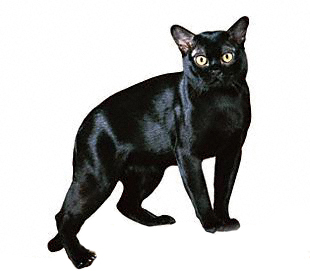

In [6]:
# 打印原图
from PIL import Image
img=Image.open('/home/aistudio/cat/images/Bombay_130.jpg')
img

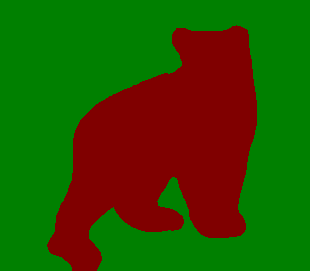

In [7]:
# 打印输出图，颜色可调
from PIL import Image
img=Image.open('/home/aistudio/PaddleSeg/output/Bombay_130.png')
img

# 八、hub部署

hub部署可参考：[PaddleHub Module转换](https://aistudio.baidu.com/aistudio/projectdetail/641317)

已用hub部署，可通过命令行或者python来抠图啦！，具体hub文件见目录压缩包catseg_mobile.zip

```
hub run catseg_mobile --input_path .\cat1.jpg
```

![](https://ai-studio-static-online.cdn.bcebos.com/102fb28c7d0c4b8cada525f690296434e7d53bc2213c4c1890fcccdc2f9b90b5)


![](https://ai-studio-static-online.cdn.bcebos.com/34fd4a91a88f4a58bf3e962807c2e26e2b5666731c27490a8626942eb014c1ca)
